# Technoedge Quickstart

In [273]:
import pynq
from pynq import Overlay
from time import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import ctypes

## Wrapper Class

In [274]:
STATUS_REGISTER = 0x0

DATA_ADDR = 512
RESULT_ADDR = 74256

FC1_WT_ADDR = 32768
FC1_BIAS_ADDR = 65536

FC2_WT_ADDR = 69632
FC2_BIAS_ADDR = 73728

FC3_WT_ADDR = 73984
FC3_BIAS_ADDR = 74240

FC1_IN = 84
FC1_OUT = 64
FC2_OUT = 16
FC3_OUT = 3

FIXED_FACTOR = 2**24

def to_int_arr(arr):
    return np.array([xi if xi >= 0 else xi + 2**32 for xi in arr]).astype(int)
        
class TechnoEdge:
    def __init__(self, filename):
        self.overlay = Overlay(filename)
        self.techno = self.overlay.technoedge_0
        
        self.write_arr = self.techno.mmio.array[DATA_ADDR // 4:DATA_ADDR // 4 + FC1_IN]
        self.read_arr = tc.techno.mmio.array[RESULT_ADDR // 4: RESULT_ADDR // 4 + FC3_OUT]
    
    def write(self, data):
        self.write_arr[:] = to_int_arr(data)
        
    def run(self):
        self.techno.write(STATUS_REGISTER, 1)
        while self.techno.read(STATUS_REGISTER) & 0x2 == 0:
            pass
        
    def run_benchmark(self, reps = 1000):
        data = to_int_arr([0] * FC1_IN)
        
        start = time()
        for _ in range(reps):
            self.write_arr[:] = data
            self.run()
            _ = self.read_arr
        end = time()

        return (end - start)/reps*1000000
    
    def get_result(self):
        return [ctypes.c_int(x).value / FIXED_FACTOR for x in self.read_arr]
    
    def put_weights(self, wts):
        #
        # FC1 weight and bias
        #
        arr = self.techno.mmio.array[FC1_WT_ADDR // 4:FC1_WT_ADDR // 4 + len(wts['fc1_wt'])]
        arr[:] = to_int_arr(wts['fc1_wt'])
        arr = self.techno.mmio.array[FC1_BIAS_ADDR // 4:FC1_BIAS_ADDR // 4 + len(wts['fc1_bias'])]
        arr[:] = to_int_arr(wts['fc1_bias'])
        
        #
        # FC2 weight and bias
        #
        arr = self.techno.mmio.array[FC2_WT_ADDR // 4:FC2_WT_ADDR // 4 + len(wts['fc2_wt'])]
        arr[:] = to_int_arr(wts['fc2_wt'])
        arr = self.techno.mmio.array[FC2_BIAS_ADDR // 4:FC2_BIAS_ADDR // 4 + len(wts['fc2_bias'])]
        arr[:] = to_int_arr(wts['fc2_bias'])
        
        #
        # FC3 weight and bias
        #
        arr = self.techno.mmio.array[FC3_WT_ADDR // 4:FC3_WT_ADDR // 4 + len(wts['fc3_wt'])]
        arr[:] = to_int_arr(wts['fc3_wt'])
        arr = self.techno.mmio.array[FC3_BIAS_ADDR // 4:FC3_BIAS_ADDR // 4 + len(wts['fc3_bias'])]
        arr[:] = to_int_arr(wts['fc3_bias'])

## Power Management (CPU)

In [8]:
def set_cpu_freq_mhz(freq):
    if freq == 300:
        freq = 200000
    if freq == 400:
        freq = 350000
    if freq == 600:
        freq = 400000
    if freq == 1200:
        freq = 600000
    !echo $freq > /sys/devices/system/cpu/cpu0/cpufreq/scaling_setspeed
    !cat  /sys/devices/system/cpu/cpu0/cpufreq/cpuinfo_cur_freq
    !echo $freq > /sys/devices/system/cpu/cpu1/cpufreq/scaling_setspeed
    !cat  /sys/devices/system/cpu/cpu1/cpufreq/cpuinfo_cur_freq

In [9]:
tc = TechnoEdge('/home/xilinx/jupyter_notebooks/frontier/capstone_full.bit')
rails = pynq.get_rails()

299999
299999
399999
399999
599999
599999
1199998
1199998


Text(0,0.5,'Average Power Consumption (W)')

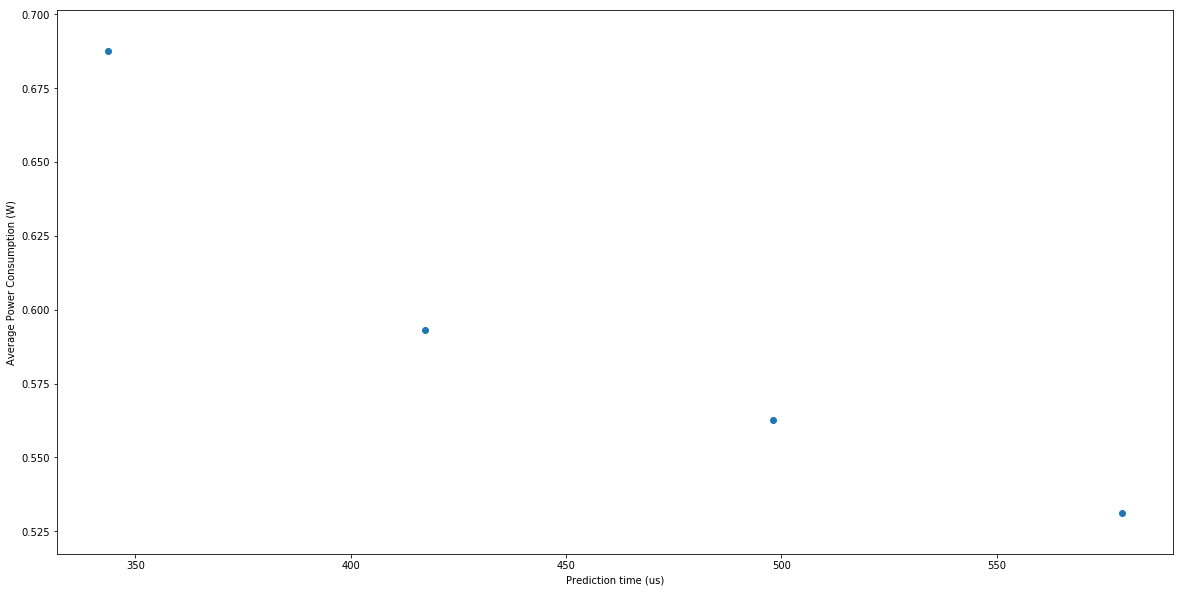

In [18]:
powers = []
times = []

for freq in [300, 400, 600, 1200]:
    set_cpu_freq_mhz(freq)
    recorder = pynq.DataRecorder(rails['PSINT_FP'].power)
    with recorder.record(0.2):
        duration = tc.run_benchmark(10000)
    power = recorder.frame['PSINT_FP_power'].mean()
    times.append(duration)
    powers.append(power)

plt.clf()
plt.figure(figsize=(20,10))
plt.scatter(times, powers)
plt.xlabel("Prediction time (us)")
plt.ylabel("Average Power Consumption (W)")

## Power Management (FPGA)

In [19]:
def set_fpga_freq(freq):
    pynq.ps.Clocks.fclk0_mhz = freq
    pynq.ps.Clocks.fclk1_mhz = freq
    pynq.ps.Clocks.fclk2_mhz = freq
    pynq.ps.Clocks.fclk3_mhz = freq

/usr/local/lib/python3.6/dist-packages/pynq/ps.py:464: UserWarning: Setting frequency to the closest possible value 40.54014MHz.
  round(freq_high / q0, 5)))
/usr/local/lib/python3.6/dist-packages/pynq/ps.py:464: UserWarning: Setting frequency to the closest possible value 71.42786MHz.
  round(freq_high / q0, 5)))
/usr/local/lib/python3.6/dist-packages/pynq/ps.py:464: UserWarning: Setting frequency to the closest possible value 78.94658MHz.
  round(freq_high / q0, 5)))
/usr/local/lib/python3.6/dist-packages/pynq/ps.py:464: UserWarning: Setting frequency to the closest possible value 88.23441MHz.
  round(freq_high / q0, 5)))


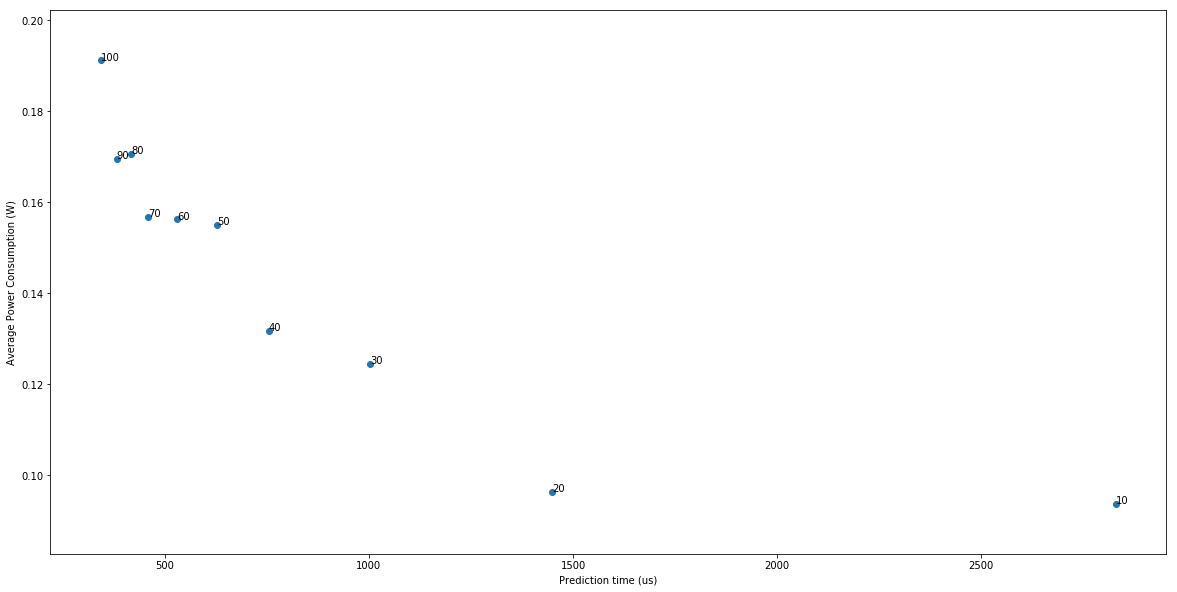

In [20]:
iterations = 10000
powers = []
times = []
freqs = []

for freq in range(10, 110, 10): # rails.keys():
    set_fpga_freq(freq)
    freqs.append(freq)
    rail = 'INT'
    
    recorder = pynq.DataRecorder(rails[rail].power)
    with recorder.record(0.2):
        pred_time = tc.run_benchmark(iterations)
    
    power = recorder.frame[recorder.frame.columns[1]].mean()
    times.append(pred_time)
    powers.append(power)


plt.clf()
plt.figure(figsize=(20,10))
plt.scatter(times, powers)
plt.xlabel("Prediction time (us)")
plt.ylabel("Average Power Consumption (W)")

for i in range(0, len(times)):
    plt.text(times[i], powers[i], freqs[i])

## Examples

In [275]:
tc = TechnoEdge('/home/xilinx/jupyter_notebooks/frontier/capstone_full.bit')

In [276]:
# load weights from file
f = open("wts", "rb")
wts = np.load(f)
tc.put_weights(wts)
f.close()

In [277]:
print("It takes %dus per inference on average." % tc.run_benchmark(1000))  

It takes 111us per inference on average.


In [278]:
f = open("testv", "rb")
data = np.load(f)['testv']
f.close()

tc.write(data)
tc.run()

result = tc.get_result()
print("Result is", result)

Result is [-0.04226440191268921, -0.04347771406173706, -0.024767398834228516]
